In [31]:
from astropy.io import fits
from astropy.time import Time
from scipy.ndimage import rotate
from _mypath import thisdir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [32]:
def get_path(*rela_path, to_file=True):
    """get an absolute path
    if to_file=True, the path will link to a .img.gz file according to inputted OBS_ID and FILTER
    if to_file=False, the path will link to any file/dir according to the rela_path
    
    Inputs: 
    1) 'OBS_ID', 'FILTER' or 2) 'rela_path', to_file=F
    Outpus: 
    absolute path, string
    """
    if to_file == True:
        print(rela_path)
        data_path = '../data/Borisov_raw/'
        map_path = './uvot/image/'
        file_name = 'sw' + rela_path[0] + rela_path[1] + '_sk.img.gz'
        path = os.path.join(thisdir, data_path, rela_path[0], map_path, file_name)
        print(path)
        return path
    else:
        return os.path.join(thisdir, rela_path[0])

In [33]:
def set_coord(image_array, target_index,
              size):
    """To shift a target on an image 
    into the center of a new image;
    
    The size of the new image can be given 
    but have to ensure the whole original
    image is included in the new one.
    
    Inputs: array of an original image, 2D array
            original coordinate values of the target, array shape in [r, c]
            output size, tuple of 2 elements
    Outputs: array of the shifted image in the new coordinate, 2D array
    """
    # interpret the size and create new image
    try:
        half_row, half_col = size
    except:
        print("Check the given image size!")
    new_coord = np.zeros((2*half_row - 1, 
                          2*half_col - 1))
    # shift the image, [target] -> [center]
    def shift_r(r):
        return int(r+(half_row-1- target_index[0]))
    def shift_c(c):
        return int(c+(half_col-1- target_index[1]))
    for r in range(image_array.shape[0]):
        for c in range(image_array.shape[1]):
            new_coord[shift_r(r), 
                      shift_c(c)] = image_array[r, c]
    # reture new image
    return new_coord

In [34]:
#### Here is an example of set_coord() and rotate()
# create an orignal array
image_array_test = np.array([[1 ,5, 6, 1],
                             [2, 9, 0, 6],
                             [7, 7, 5, 4]])
target_index_test = np.array([0, 0]) #get target index
new_coord_test = set_coord(image_array_test, target_index_test, (5, 5)) # shift the original array
rotated_image_test = rotate(new_coord_test, angle=40., reshape=False, order=1) # rotate the shifted array
rotated_image_test = np.around(rotated_image_test, decimals=2) # simplify the output
print("original image array:")
print(image_array_test)
print("\ntarget index:")
print(target_index_test)
print("\nshift the target to the center:")
print(new_coord_test)
print("\nrotate the image for 40 deg:")
print(rotated_image_test)

original image array:
[[1 5 6 1]
 [2 9 0 6]
 [7 7 5 4]]

target index:
[0 0]

shift the target to the center:
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 5. 6. 1. 0.]
 [0. 0. 0. 0. 2. 9. 0. 6. 0.]
 [0. 0. 0. 0. 7. 7. 5. 4. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

rotate the image for 40 deg:
[[0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.64 1.44 1.24 0.  ]
 [0.   0.   0.   0.   0.84 4.74 3.01 5.39 1.29]
 [0.   0.   0.   0.08 1.   6.18 4.7  4.49 1.61]
 [0.   0.   0.   0.   0.63 4.55 6.64 1.74 0.  ]
 [0.   0.   0.   0.   0.   2.78 1.28 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [35]:
def sum_image(obs_log_name, filt, size, ouput_name):
    '''sum obs images according to 'FILTER'
    
    Inputs:
    obs_log_name: the name of an obs log in docs/
    filt: 'uvv' or 'uw1' or 'uw2'
    size: a tuple
    output_name: string, to be saved in docs/
    
    Outputs:
    1) a txt data file saved in docs/
    2) a fits file saved in docs/
    '''
    # load obs_log in DataFrame according to filt
    obs_log_path = get_path('../docs/'+obs_log_name,
                            to_file=False)
    img_set = pd.read_csv(obs_log_path, sep=' ',
                          index_col=['FILTER'])
    img_set = img_set[['OBS_ID', 'EXTENSION',
                       'PX', 'PY', 'PA']]
    if filt == 'uvv':
        img_set = img_set.loc['V']
    if filt == 'uw1':
        img_set = img_set.loc['UVW1']
    if filt == 'uw2':
        img_set = img_set.loc['UVW2']
    #---transfer OBS_ID from int to string---
    img_set["OBS_ID"]=img_set["OBS_ID"].astype(str)
    img_set["OBS_ID"]='000'+img_set["OBS_ID"]
    # create a blank canvas in new coordinate
    summed_img = np.zeros((2*size[0] - 1,
                           2*size[1] - 1))
    # loop among the data set, for every image, shift it to center the target, rotate and add to the blank canvas
    for i in range(len(img_set)):
        #---get data from .img.gz---
        img_now = img_set.iloc[i]
        img_path = get_path(img_now["OBS_ID"], 
                            filt)
        img_data = fits.open(img_path)[img_now['EXTENSION']].data.T # .T! or else hdul PXY =/= DS9 PXY
        #---shift the image to center the target---
        new_img = set_coord(img_data, 
                            np.array([img_now['PX'],
                                      img_now['PY']]),
                            size)
        #---rotate the image according to PA to
        #---eliminate changes of pointing
        #---this rotating step may be skipped---
        new_img = rotate(new_img, 
                         angle=img_now['PA'],
                         reshape=False,
                         order=1)
        #---sum modified images to the blank canvas---
        summed_img = summed_img + new_img
    # get the summed results and save
    #---save in txt file---
    ouput_path = get_path('../docs/'+ouput_name+
                          '_'+filt, to_file=False)
    np.savetxt(ouput_path, summed_img, 
               delimiter=' ', fmt='%.7f')
    #---save in fits file---
    hdu = fits.PrimaryHDU(stacked_img)
    hdu.writeto(ouput_path+'.fits')

In [36]:
def plot_sum(img_name, out_name):
    # read data from txt file
    img_path = get_path('../docs/'+img_name, 
                        to_file=False)
    img_data = np.loadtxt(img_path, delimiter=' ')
    # generate title by output name automatically
    out_path = get_path('../docs/'+out_name,
                        to_file=False)
    title_name = out_name[:-4].split('_')
    title_name = ' '.join(title_name)
    # plot the summed image
    fig = plt.figure(figsize=(30,30))
    ax = fig.add_subplot(111)
    plt.grid(alpha=0.3, ls='--')
    plt.imshow(img_data, vmin=0, vmax=np.max(img_data)*0.01)
    cbar = plt.colorbar(aspect=30, shrink=0.82)
    cbar.ax.tick_params(labelsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.title(title_name, fontsize=30)
    plt.savefig(out_path, dpi=100)
    plt.show()

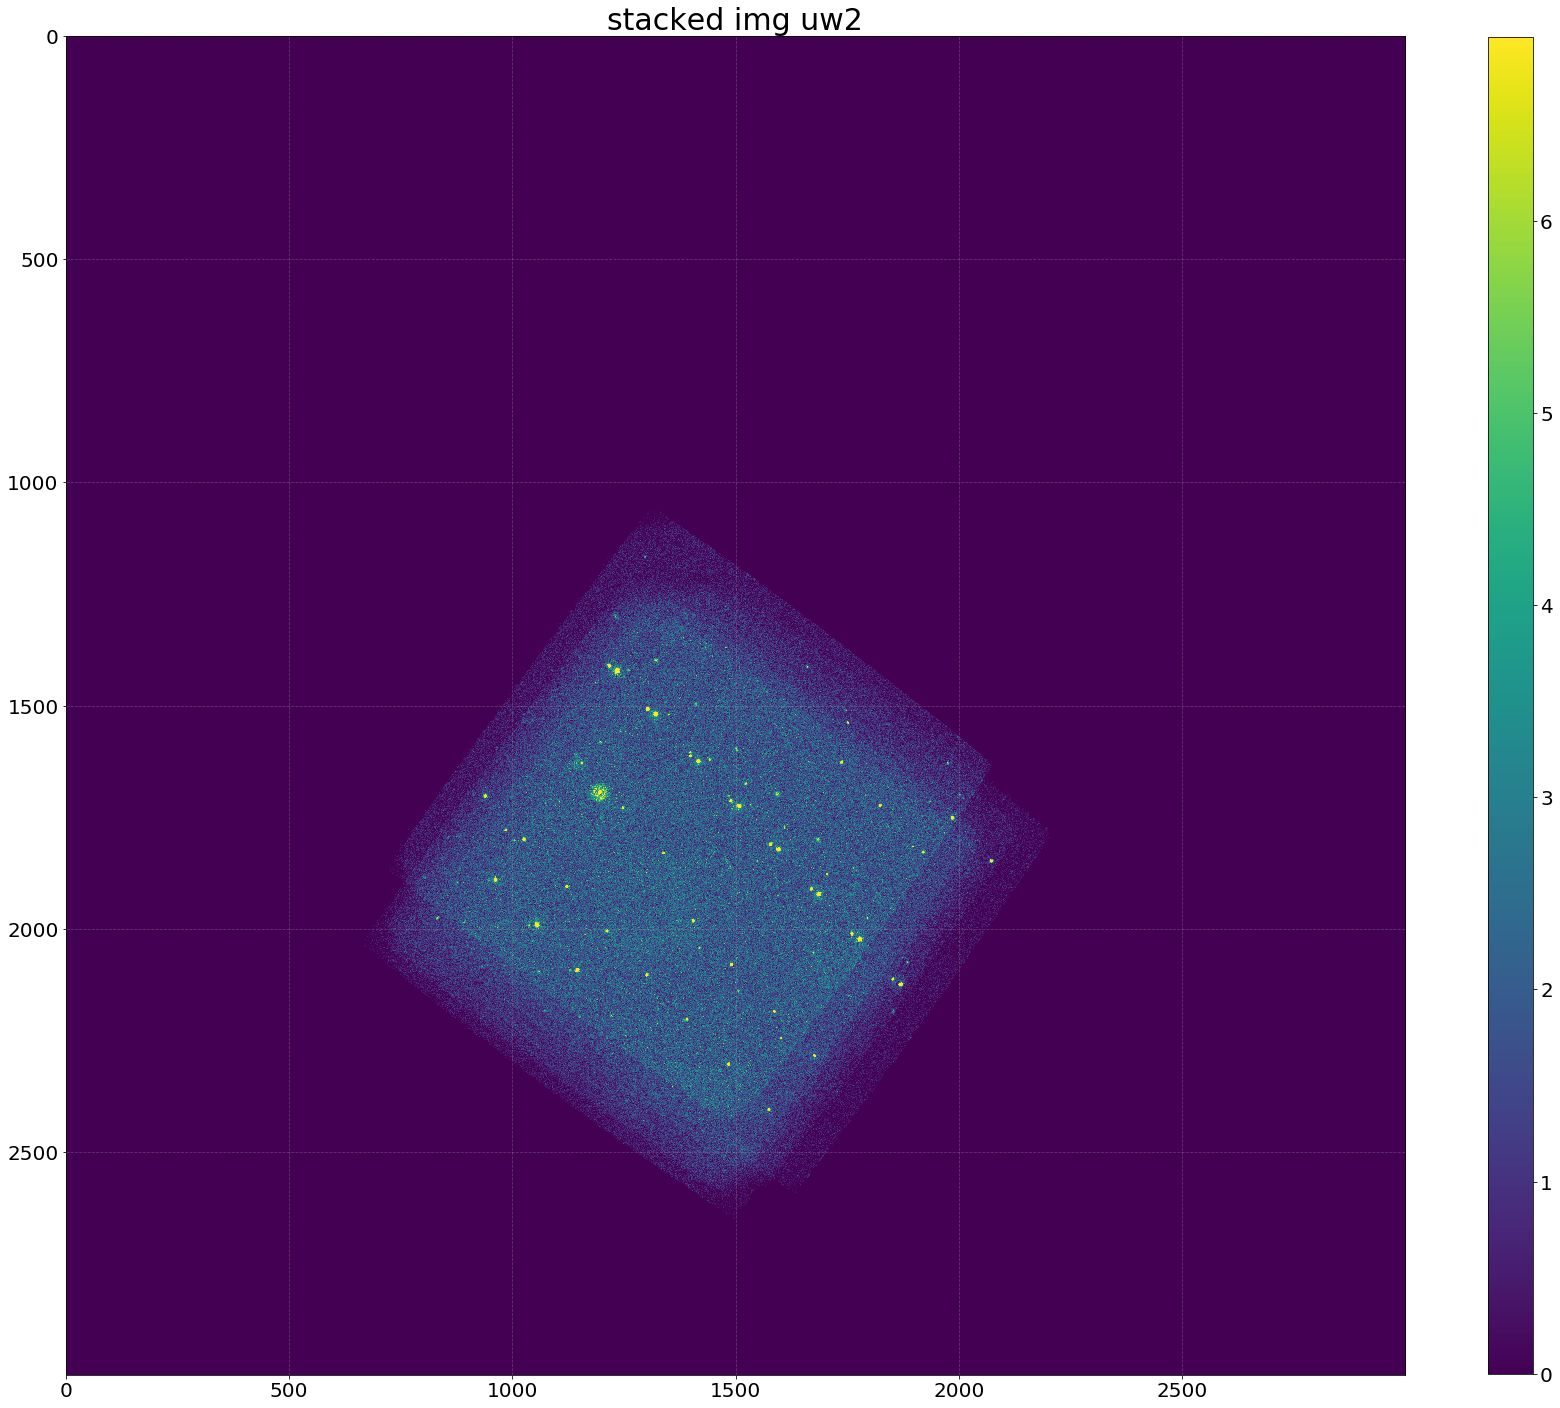

In [44]:
#sum_image('obs-log_Borisov_ZX.txt', 'uw2', (1500,1500), 'summed_img')
plot_sum('summed_img_uw2', 'summed_img_uw2.png')